## Checking whether my motif distance matrix calculations are correct

In [167]:
import theano
from sklearn.model_selection import ParameterGrid

In [2]:
import os
import sys 
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.preprocessing import StandardScaler

In [3]:
a = np.arange(1953*1953).reshape(1953, 1953)

In [4]:
iu1 = np.triu_indices(1953)

In [5]:
iu1[0]

array([   0,    0,    0, ..., 1951, 1951, 1952])

In [244]:
import motif_processor
reload(motif_processor)

<module 'motif_processor' from 'motif_processor.pyc'>

In [245]:
HepG2MotifProcObj = motif_processor.MotifProcessor(ENCODE_only=False, 
                                                   cell_line="HepG2", 
                                                   meme_file="/home/alvin/Dropbox/Lab/CNN/data/meme/HepG2_pos_steme/steme.txt")
HepG2_motif_tensor, HepG2_motif_names = HepG2MotifProcObj.generate_custom_CNN_filters(max_length = 18, padding = 0, truncate = False)

K562MotifProcObj = motif_processor.MotifProcessor(ENCODE_only=False, 
                                                   cell_line="K562", 
                                                   meme_file="/home/alvin/Dropbox/Lab/CNN/data/meme/K562_pos_steme/steme.txt")
K562_motif_tensor, K562_motif_names = K562MotifProcObj.generate_custom_CNN_filters(max_length = 18, padding = 0, truncate = False)


LCLMotifProcObj = motif_processor.MotifProcessor(ENCODE_only=False, 
                                                   cell_line="LCL", 
                                                   meme_file="/home/alvin/Dropbox/Lab/CNN/data/meme/LCL_pos_steme/steme.txt")
LCL_motif_tensor, LCL_motif_names = LCLMotifProcObj.generate_custom_CNN_filters(max_length = 18, padding = 0, truncate = False)


In [246]:
MotifProcObj = motif_processor.MotifProcessor(ENCODE_only=True, 
                                                   cell_line="HepG2", 
                                                  meme_file="/home/alvin/Dropbox/Lab/CNN/data/meme/HepG2_pos_steme/steme.txt")
motif_tensor, motif_names = MotifProcObj.generate_custom_CNN_filters(max_length = 18, padding = 0, truncate = False)


In [247]:
motifDistanceProcessorObj = motif_processor.MotifDistanceProcessor([],[],[])

In [248]:
binary_mat = motifDistanceProcessorObj.process_Pouya(motif_names)

In [249]:
print(binary_mat.shape)

(1953, 167)


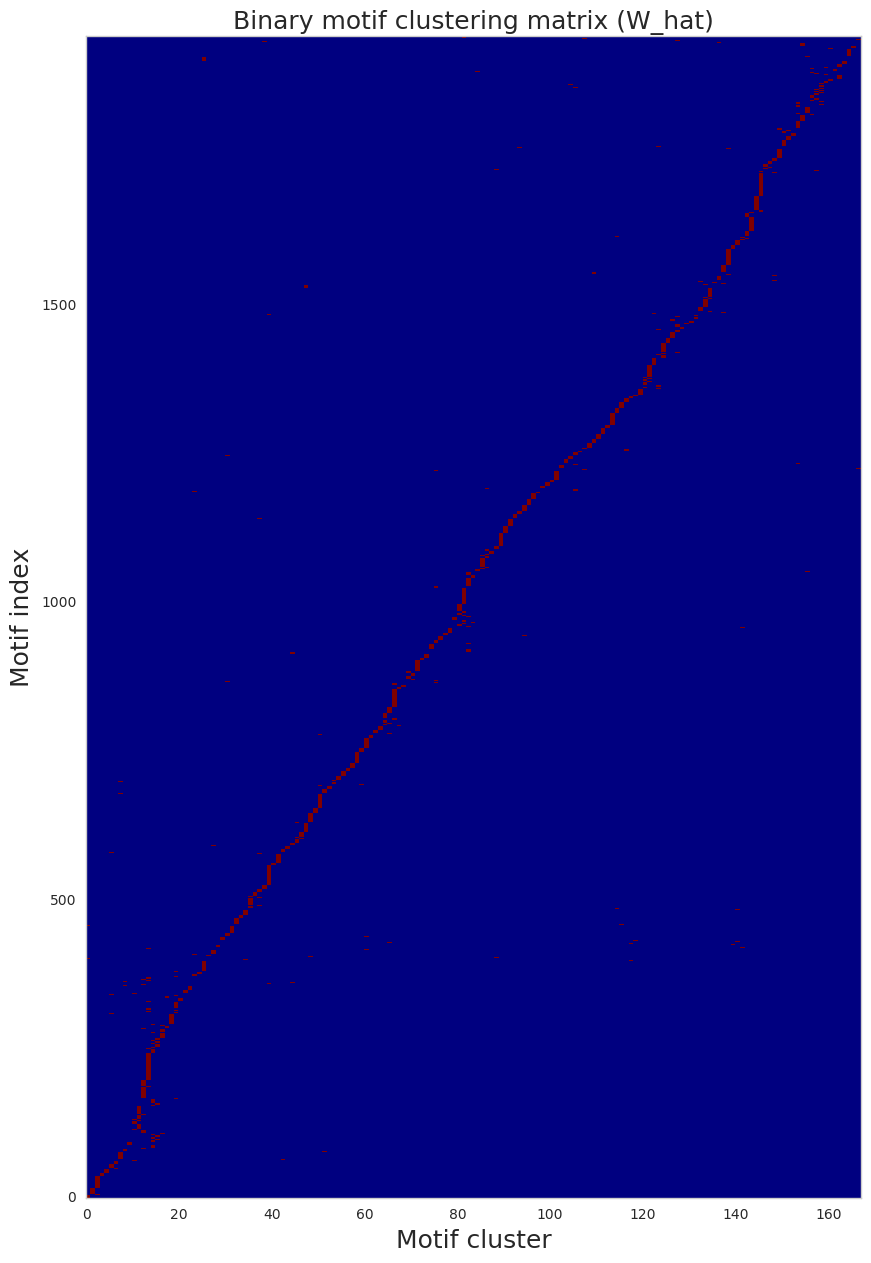

In [250]:
plt.figure(figsize=(10,15))
plt.pcolor(binary_mat,cmap='jet')
plt.axis('tight')
plt.xlabel('Motif cluster',fontsize=18)
plt.ylabel('Motif index',fontsize=18)
plt.title("Binary motif clustering matrix (W_hat)",fontsize=18)
plt.savefig("clustered_binary_motifs.png", dpi=300)
plt.show()

In [184]:
binary_mat.shape

(1953, 126)

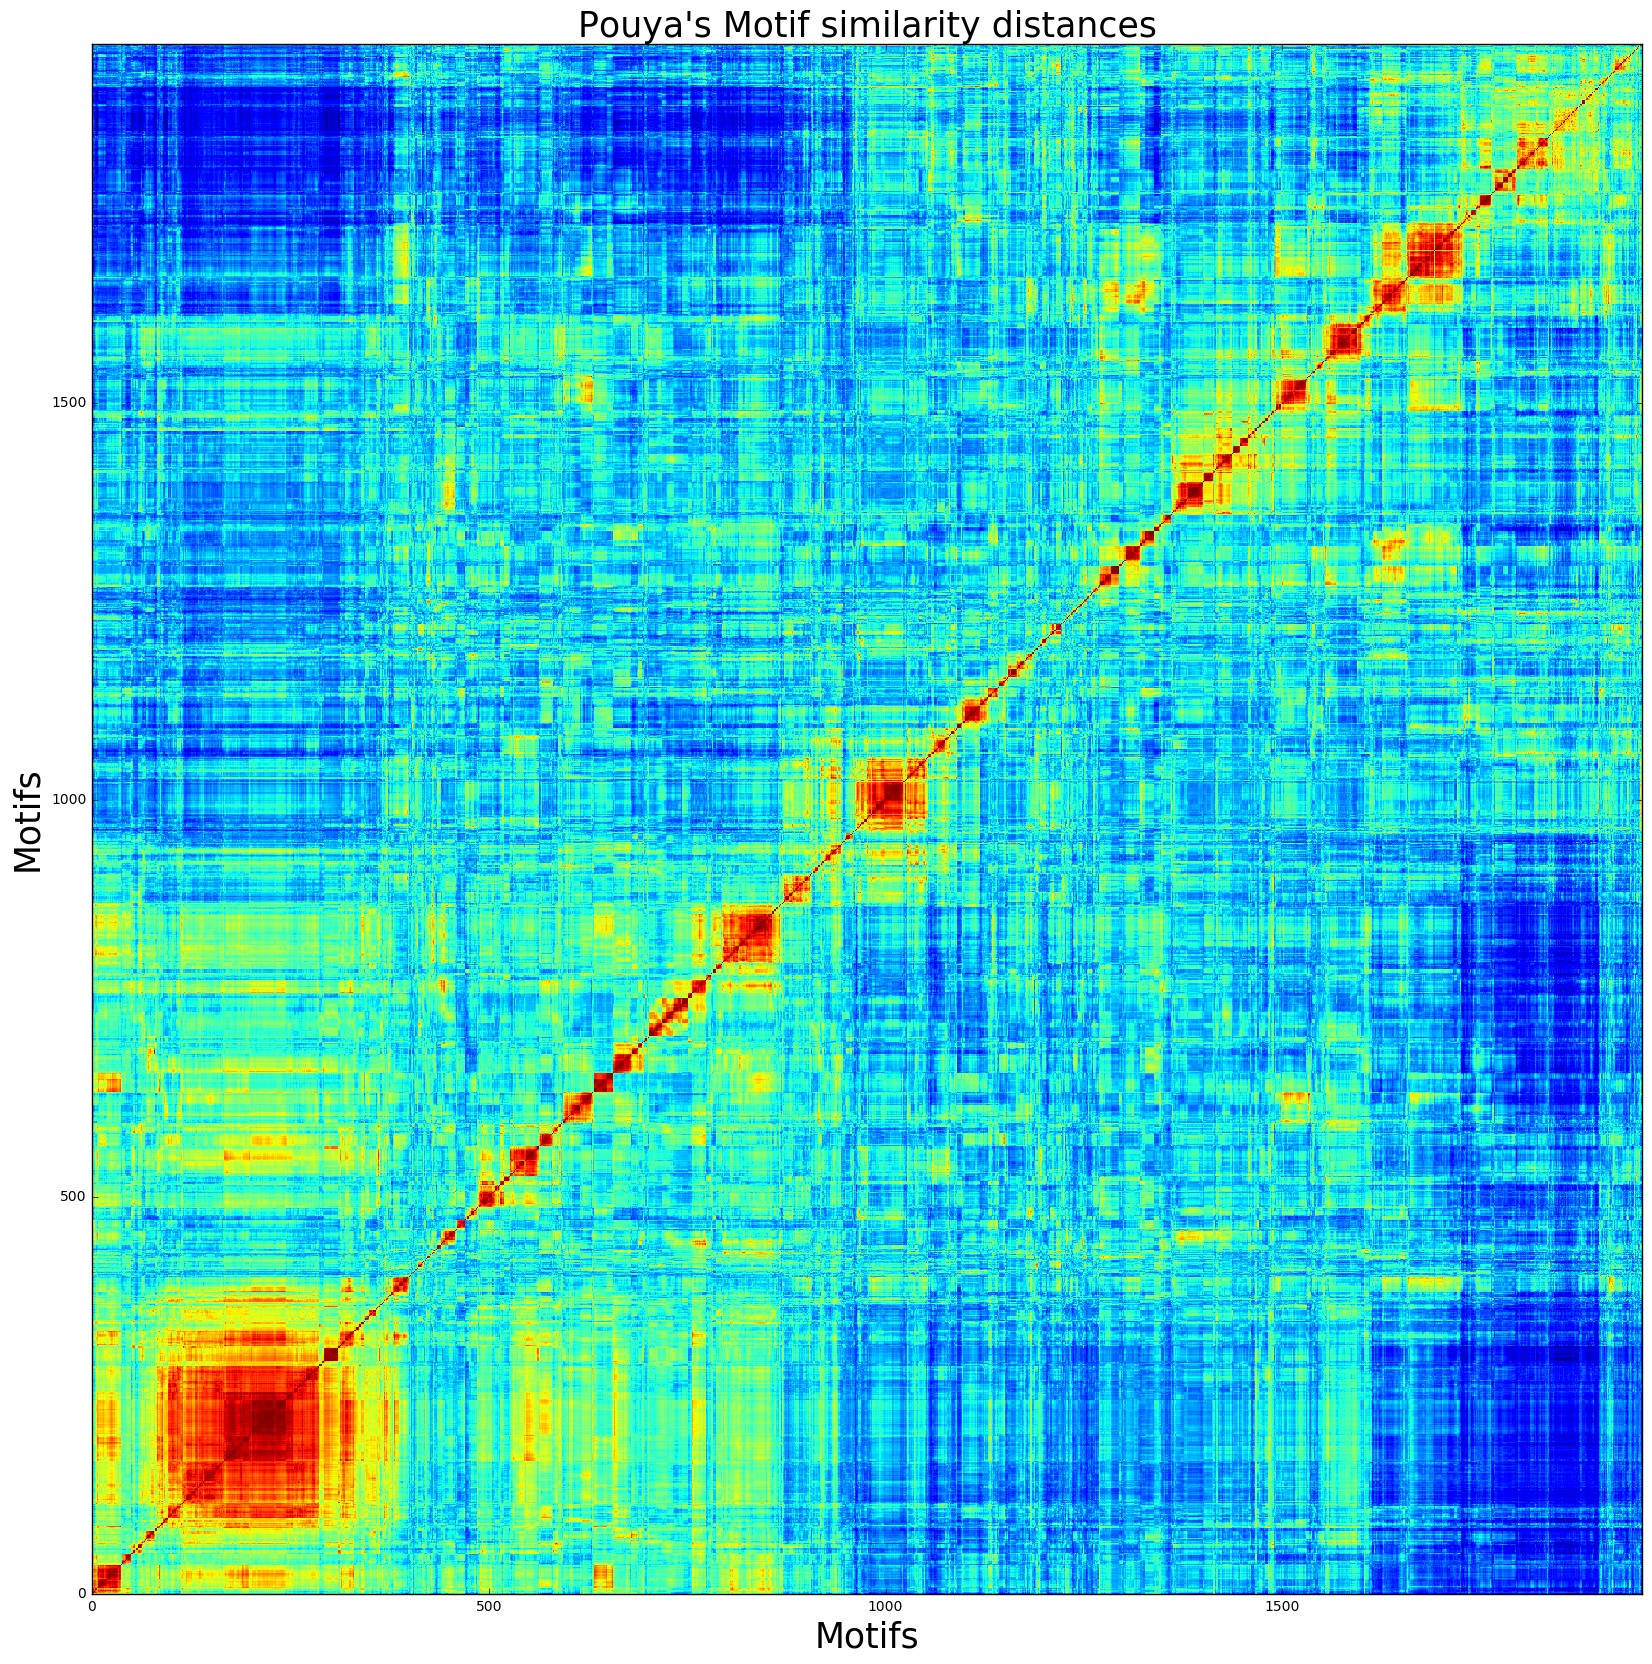

In [127]:
plt.figure(figsize=(20,20))
plt.pcolor(df)
plt.axis('tight')
plt.xlabel('Motifs',fontsize=25)
plt.ylabel('Motifs',fontsize=25)
plt.title("Pouya's Motif similarity distances",fontsize=25)
plt.savefig("Pouya_motifs.png", dpi=300)
plt.show()

In [151]:
clus_labels=motifDistanceProcessorObj.cluster_Pouya(mat,verbose=True, damping=0.9, preference=0.01)

Converged after 91 iterations.


In [183]:
clus_labels.shape

(1953,)

In [251]:
cur_max=np.max(clus_labels)
plt.figure(figsize=(12,10))
plt.hist(clus_labels,bins=cur_max)
plt.xlabel('Cluster index',fontsize=18)
plt.xlim([0,cur_max])
plt.ylabel('Number of motifs in cluster',fontsize=18)
plt.title('Number of motifs vs. cluster index (%i total clusters)'%(cur_max),fontsize=18)
plt.savefig('motif_cluster_distribution.png', dpi=300)
plt.show()

NameError: name 'clus_labels' is not defined

# Training CNN time!

In [252]:
import common_utils
reload(common_utils)

<module 'common_utils' from 'common_utils.pyc'>

In [253]:
CrossValProcObj = common_utils.CrossValProcessor(output_dirs = ["./HEPG2_act_1_31/", "./HEPG2_rep_1_31/", 
                                                                      "./K562_act_1_31/", "./K562_act_1_31/",
                                                                      "./LCL_act_alt_1_31/"])

HepG2_binObj = CrossValProcObj.HepG2_binObj
K562_binObj = CrossValProcObj.K562_binObj
LCL_binObj = CrossValProcObj.LCL_binObj
binObjs = [HepG2_binObj, K562_binObj, LCL_binObj]
CvDicts = [CrossValProcObj.HepG2_dict, CrossValProcObj.K562_dict, CrossValProcObj.LCL_dict]
motif_tensors = [motif_tensor, motif_tensor, motif_tensor]
motif_names = [motif_names, motif_names, motif_names]
names=["HepG2", "K562", "LCL"]
dirs = ["./HepG2_1_31/", "./K562_1_31/", "./LCL_1_31/"]


In [254]:
import cv_engine 
reload(cv_engine)

<module 'cv_engine' from 'cv_engine.pyc'>

In [255]:
HepG2DataConvObj = cv_engine.DataConvolver(HepG2_binObj.merged_tensor, HepG2_binObj.merged_RC_tensor, HepG2_binObj.merged_tar, motif_tensor.shape, features_mat=HepG2_binObj.features_mat, should_conv=False)
K562DataConvObj = cv_engine.DataConvolver(K562_binObj.merged_tensor, K562_binObj.merged_RC_tensor, K562_binObj.merged_tar, motif_tensor.shape, features_mat=K562_binObj.features_mat,should_conv=False) 
LCLDataConvObj = cv_engine.DataConvolver(LCL_binObj.merged_tensor, LCL_binObj.merged_RC_tensor, LCL_binObj.merged_tar, motif_tensor.shape,features_mat=LCL_binObj.features_mat, should_conv=False) 

In [256]:
import keras_motif
reload(keras_motif)

<module 'keras_motif' from 'keras_motif.pyc'>

In [219]:
import random
import multiprocessing
from multiprocessing import Pool, Process

In [268]:
def Process2(param_list):
    binObjs = [HepG2DataConvObj,K562DataConvObj,LCLDataConvObj]
    names=['HepG2','K562','LCL']
    model_names = ['Meta', 'Double', 'Simple']
    pool_width = param_list['pool_width']
    weighted = param_list['weighted']
    L2 = param_list['L2']
    L1 = param_list['L1']
    dropout = param_list['dropout']
    results_dict = {}
    results_dict['parameters']=param_list
    results_dict['training_history']=[]
    results_dict['performance']=[]
    for idx, binObj in enumerate(binObjs):
        cur_name = names[idx]
        if idx == 0:
            print "continue"
            continue
        if idx == 1:
            print "continue"
            continue 
        if idx == 2:
            testObj1 = binObjs[1]
            testName1 = names[1]
            testObj2 = binObjs[0]
            testName2 = names[0]
        model1 = keras_motif.MetaKerasModel(binObj, motif_tensor, binary_mat)
        model2 = keras_motif.DoubleKerasModel(binObj, motif_tensor)
        model3 = keras_motif.SimpleKerasModel(binObj)
        Models = [model1, model2, model3]
        for model_idx, Model in enumerate(Models):
            Model.build_model(dropout=dropout, L1=L1, L2=L2, pool_width=pool_width, weighted=weighted)
            pos_weight, neg_weight = cv_engine.get_weights(binObj.Y)
            train_history = Model.train(binObj.X, binObj.X_RC, binObj.features_mat, binObj.Y, neg_weight, pos_weight) 
            results_dict['training_history'].append(train_history)
            testPred1 = Model.predict(testObj1.X, testObj1.X_RC, testObj1.features_mat)
            testPred2 = Model.predict(testObj2.X, testObj2.X_RC, testObj2.features_mat)
            testResult1 = str(common_utils.ClassificationResult(testObj1.Y.astype(bool),testPred1.flatten()))
            testResult2 = str(common_utils.ClassificationResult(testObj2.Y.astype(bool),testPred2.flatten()))
            result1 = '%s\t%s\t%s\t%i\t%i\t%0.04f\t%0.04f\t%0.02f\t%s'%(cur_name, model_names[model_idx], testName1, int(pool_width), int(weighted), L1,L2,dropout, testResult1)
            result2 = '%s\t%s\t%s\t%i\t%i\t%0.04f\t%0.04f\t%0.02f\t%s'%(cur_name, model_names[model_idx], testName2, int(pool_width), int(weighted), L1,L2,dropout, testResult2)
            print result1
            print result2
            results_dict['performance'].append(result1)
            results_dict['performance'].append(result2)
    return results_dict
    

In [ ]:
results = map(Process2, param_list)

continue
continue
LCL	Meta	K562	61	1	0.1000	1.0000	0.20	nan	64.1205	0.8027	0.4566	0.8429	0.0000	0.0000	0.0000	0.0000	1595.0000	11398.0000
LCL	Meta	HepG2	61	1	0.1000	1.0000	0.20	nan	61.0624	0.7333	0.3977	0.7580	0.0000	0.0000	0.0000	0.0000	1691.0000	10478.0000
LCL	Double	K562	61	1	0.1000	1.0000	0.20	nan	71.5032	0.8323	0.5271	0.9144	0.0000	0.0000	0.0000	21.2539	1595.0000	11398.0000
LCL	Double	HepG2	61	1	0.1000	1.0000	0.20	nan	66.9189	0.7730	0.4635	0.8514	0.0000	0.0000	0.0000	0.0000	1691.0000	10478.0000
LCL	Simple	K562	61	1	0.1000	1.0000	0.20	nan	68.0978	0.7995	0.4780	0.8723	0.0000	0.0000	0.0000	0.0000	1595.0000	11398.0000
LCL	Simple	HepG2	61	1	0.1000	1.0000	0.20	nan	64.4519	0.7479	0.4430	0.8200	0.0000	0.0000	0.0000	0.0000	1691.0000	10478.0000
continue
continue
LCL	Meta	K562	14	0	0.1000	1.0000	0.10	nan	71.3195	0.8023	0.4830	0.8295	0.0000	0.0000	0.0000	0.0000	1595.0000	11398.0000
LCL	Meta	HepG2	14	0	0.1000	1.0000	0.10	nan	66.3393	0.7497	0.4457	0.7686	0.0000	0.0000	0.0000	0.0000	1691.0000	10

In [257]:
def Process(param_list):
    binObjs = [HepG2DataConvObj,K562DataConvObj,LCLDataConvObj]
    names=['HepG2','K562','LCL']
    model_names = ['Meta', 'Double', 'Simple']
    pool_width = param_list['pool_width']
    weighted = param_list['weighted']
    L2 = param_list['L2']
    L1 = param_list['L1']
    dropout = param_list['dropout']
    results_dict = {}
    results_dict['parameters']=param_list
    results_dict['training_history']=[]
    results_dict['performance']=[]
    for idx, binObj in enumerate(binObjs):
        cur_name = names[idx]
        if idx == 0:
            testObj1 = binObjs[1]
            testName1 = names[1]
            testObj2 = binObjs[2]
            testName2 = names[2]
        if idx == 1:
            testObj1 = binObjs[0]
            testName1 = names[0]
            testObj2 = binObjs[2]
            testName2 = names[2]       
        if idx == 2:
            testObj1 = binObjs[1]
            testName1 = names[1]
            testObj2 = binObjs[0]
            testName2 = names[0]
        model1 = keras_motif.MetaKerasModel(binObj, motif_tensor, binary_mat)
        model2 = keras_motif.DoubleKerasModel(binObj, motif_tensor)
        model3 = keras_motif.SimpleKerasModel(binObj)
        Models = [model1, model2, model3]
        for model_idx, Model in enumerate(Models):
            Model.build_model(dropout=dropout, L1=L1, L2=L2, pool_width=pool_width, weighted=weighted)
            pos_weight, neg_weight = cv_engine.get_weights(binObj.Y)
            train_history = Model.train(binObj.X, binObj.X_RC, binObj.features_mat, binObj.Y, neg_weight, pos_weight) 
            results_dict['training_history'].append(train_history)
            testPred1 = Model.predict(testObj1.X, testObj1.X_RC, testObj1.features_mat)
            testPred2 = Model.predict(testObj2.X, testObj2.X_RC, testObj2.features_mat)
            testResult1 = str(common_utils.ClassificationResult(testObj1.Y.astype(bool),testPred1.flatten()))
            testResult2 = str(common_utils.ClassificationResult(testObj2.Y.astype(bool),testPred2.flatten()))
            result1 = '%s\t%s\t%s\t%i\t%i\t%0.04f\t%0.04f\t%0.02f\t%s'%(cur_name, model_names[model_idx], testName1, int(pool_width), int(weighted), L1,L2,dropout, testResult1)
            result2 = '%s\t%s\t%s\t%i\t%i\t%0.04f\t%0.04f\t%0.02f\t%s'%(cur_name, model_names[model_idx], testName2, int(pool_width), int(weighted), L1,L2,dropout, testResult2)
            print result1
            print result2
            results_dict['performance'].append(result1)
            results_dict['performance'].append(result2)
    return results_dict
    

In [ ]:
param_grid = {'pool_width':[2,3,4,5,6,8,12,14,20,61], 'weighted': [True, False],'L2':[0,0.0001,0.01,0.1,1], 'L1': [0,0.001,0.1,1], 'dropout':[0,0.1,0.2]}
param_list = list(ParameterGrid(param_grid))
param_list = param_list[::-1]
random.shuffle(param_list)

In [ ]:
results = map(Process, param_list)

HepG2	Meta	K562	61	1	0.1000	1.0000	0.20	nan	75.2913	0.8086	0.5034	0.8906	0.0000	0.0000	0.0000	0.0000	1595.0000	11398.0000
HepG2	Meta	LCL	61	1	0.1000	1.0000	0.20	nan	57.5538	0.5834	0.2716	0.5782	0.0000	0.0000	0.0000	0.0000	2770.0000	18100.0000
HepG2	Double	K562	61	1	0.1000	1.0000	0.20	nan	74.2403	0.7938	0.5045	0.9066	0.0000	0.0000	12.4138	19.0596	1595.0000	11398.0000
HepG2	Double	LCL	61	1	0.1000	1.0000	0.20	nan	59.8439	0.6440	0.3160	0.6965	0.0000	0.0000	0.0000	0.0000	2770.0000	18100.0000
HepG2	Simple	K562	61	1	0.1000	1.0000	0.20	nan	66.5077	0.7121	0.3663	0.8039	0.0000	0.0000	0.0000	0.0000	1595.0000	11398.0000
HepG2	Simple	LCL	61	1	0.1000	1.0000	0.20	nan	58.8479	0.6024	0.2746	0.6157	0.0000	0.0000	0.0000	0.0000	2770.0000	18100.0000
K562	Meta	HepG2	61	1	0.1000	1.0000	0.20	nan	69.5296	0.7431	0.4357	0.8157	0.0000	0.0000	0.0000	0.0000	1691.0000	10478.0000
K562	Meta	LCL	61	1	0.1000	1.0000	0.20	nan	59.3536	0.6105	0.2991	0.6568	0.0000	0.0000	0.0000	0.0000	2770.0000	18100.0000
K562	Double	HepG2	6

In [236]:
results

NameError: name 'results' is not defined

### Unweighted

In [102]:
HepG2MetaKerasObj = keras_motif.MetaKerasModel(HepG2DataConvObj, motif_tensor, binary_mat)
HepG2MetaKerasObj.build_model(dropout=0.05, L1=0, L2=0.01, pool_width = 5, weighted=False)
pos_weight, neg_weight = cv_engine.get_weights(HepG2DataConvObj.Y)
training_history=HepG2MetaKerasObj.train(HepG2DataConvObj.X, HepG2DataConvObj.X_RC, HepG2DataConvObj.features_mat, HepG2DataConvObj.Y, neg_weight, pos_weight, nb_epoch=50,val_split=0.08, patience=8,batch_size=300,verbose=False)

33
(126, 33)


In [108]:
HepG2DoubleKeras = keras_motif.DoubleKerasModel(HepG2DataConvObj, motif_tensor)
HepG2DoubleKeras.build_model(dropout=0.05, L1=0, L2=0.01, pool_width = 5, weighted=False)
pos_weight, neg_weight = cv_engine.get_weights(HepG2DataConvObj.Y)
training_history=HepG2DoubleKeras.train(HepG2DataConvObj.X, HepG2DataConvObj.X_RC, HepG2DataConvObj.features_mat, HepG2DataConvObj.Y, neg_weight, pos_weight, nb_epoch=50,val_split=0.08, patience=8,batch_size=300,verbose=False)

In [103]:
LCL_meta_pred = HepG2MetaKerasObj.predict(LCLDataConvObj.X, LCLDataConvObj.X_RC, LCLDataConvObj.features_mat)
K562_meta_pred = HepG2MetaKerasObj.predict(K562DataConvObj.X, K562DataConvObj.X_RC, K562DataConvObj.features_mat)
HepG2_LCL_classObj = common_utils.ClassificationResult(LCLDataConvObj.Y.astype(bool),LCL_meta_pred.flatten())
print(HepG2_LCL_classObj)
HepG2_K562classObj = common_utils.ClassificationResult(K562DataConvObj.Y.astype(bool),K562_meta_pred.flatten())
print(HepG2_K562classObj)

nan	58.7505	0.6178	0.2933	0.5958	0.0000	5.6679	6.6426	10.0361	2770.0000	18100.0000
nan	71.0791	0.7882	0.4748	0.8927	0.0000	0.0000	0.0000	18.3699	1595.0000	11398.0000


In [109]:
LCL_double_pred = HepG2DoubleKeras.predict(LCLDataConvObj.X, LCLDataConvObj.X_RC, LCLDataConvObj.features_mat)
K562_double_pred = HepG2DoubleKeras.predict(K562DataConvObj.X, K562DataConvObj.X_RC, K562DataConvObj.features_mat)
HepG2_LCL_classObj = common_utils.ClassificationResult(LCLDataConvObj.Y.astype(bool),LCL_double_pred.flatten())
print(HepG2_LCL_classObj)
HepG2_K562classObj = common_utils.ClassificationResult(K562DataConvObj.Y.astype(bool),K562_double_pred.flatten())
print(HepG2_K562classObj)

0.5985	59.5953	0.6427	0.2702	0.5817	0.0004	0.3249	0.6498	0.9386	2770.0000	18100.0000
nan	73.2527	0.8107	0.4735	0.8919	0.0013	0.3135	4.7022	13.9812	1595.0000	11398.0000


## Weighted

In [106]:
HepG2MetaKerasObj = keras_motif.MetaKerasModel(HepG2DataConvObj, motif_tensor, binary_mat)
HepG2MetaKerasObj.build_model(dropout=0.05, L1=0, L2=0.01, pool_width = 5, weighted=True)
pos_weight, neg_weight = cv_engine.get_weights(HepG2DataConvObj.Y)
training_history=HepG2MetaKerasObj.train(HepG2DataConvObj.X, HepG2DataConvObj.X_RC, HepG2DataConvObj.features_mat, HepG2DataConvObj.Y, neg_weight, pos_weight, nb_epoch=50,val_split=0.08, patience=8,batch_size=300,verbose=False)

HepG2DoubleKeras = keras_motif.DoubleKerasModel(HepG2DataConvObj, motif_tensor)
HepG2DoubleKeras.build_model(dropout=0.05, L1=0, L2=0.01, pool_width = 5, weighted=True)
pos_weight, neg_weight = cv_engine.get_weights(HepG2DataConvObj.Y)
training_history=HepG2DoubleKeras.train(HepG2DataConvObj.X, HepG2DataConvObj.X_RC, HepG2DataConvObj.features_mat, HepG2DataConvObj.Y, neg_weight, pos_weight, nb_epoch=50,val_split=0.08, patience=8,batch_size=300,verbose=False)

In [105]:
LCL_meta_pred = HepG2MetaKerasObj.predict(LCLDataConvObj.X, LCLDataConvObj.X_RC, LCLDataConvObj.features_mat)
K562_meta_pred = HepG2MetaKerasObj.predict(K562DataConvObj.X, K562DataConvObj.X_RC, K562DataConvObj.features_mat)
HepG2_LCL_classObj = common_utils.ClassificationResult(LCLDataConvObj.Y.astype(bool),LCL_meta_pred.flatten())
print(HepG2_LCL_classObj)
HepG2_K562classObj = common_utils.ClassificationResult(K562DataConvObj.Y.astype(bool),K562_meta_pred.flatten())
print(HepG2_K562classObj)

nan	57.4553	0.5924	0.2656	0.5693	0.0000	0.0000	0.0000	0.0000	2770.0000	18100.0000
nan	71.4139	0.7623	0.4380	0.8681	0.0000	0.0000	0.0000	0.0000	1595.0000	11398.0000


In [107]:
LCL_double_pred = HepG2DoubleKeras.predict(LCLDataConvObj.X, LCLDataConvObj.X_RC, LCLDataConvObj.features_mat)
K562_double_pred = HepG2DoubleKeras.predict(K562DataConvObj.X, K562DataConvObj.X_RC, K562DataConvObj.features_mat)
HepG2_LCL_classObj = common_utils.ClassificationResult(LCLDataConvObj.Y.astype(bool),LCL_double_pred.flatten())
print(HepG2_LCL_classObj)
HepG2_K562classObj = common_utils.ClassificationResult(K562DataConvObj.Y.astype(bool),K562_double_pred.flatten())
print(HepG2_K562classObj)

0.5108	58.4312	0.6530	0.3187	0.6710	0.0004	2.3466	4.5126	10.0722	2770.0000	18100.0000
0.5378	74.9499	0.8275	0.5208	0.9160	0.0006	3.1975	8.1505	20.5016	1595.0000	11398.0000


## Max vs sum merge

In [260]:
HepG2MetaKerasObj = keras_motif.MetaKerasModel(HepG2DataConvObj, motif_tensor, binary_mat)
HepG2MetaKerasObj.build_model(dropout=0.1, L1=0, L2=0.001, pool_width = 8, weighted=True,merge_mode="sum")
pos_weight, neg_weight = cv_engine.get_weights(HepG2DataConvObj.Y)
training_history=HepG2MetaKerasObj.train(HepG2DataConvObj.X, HepG2DataConvObj.X_RC, HepG2DataConvObj.features_mat, HepG2DataConvObj.Y, neg_weight, pos_weight, nb_epoch=50,val_split=0.08, patience=8,batch_size=300,verbose=False)
HepG2DoubleKeras = keras_motif.DoubleKerasModel(HepG2DataConvObj, motif_tensor)
HepG2DoubleKeras.build_model(dropout=0.1, L1=0, L2=0.001, pool_width = 8, weighted=True,merge_mode="sum")
pos_weight, neg_weight = cv_engine.get_weights(HepG2DataConvObj.Y)
training_history=HepG2DoubleKeras.train(HepG2DataConvObj.X, HepG2DataConvObj.X_RC, HepG2DataConvObj.features_mat, HepG2DataConvObj.Y, neg_weight, pos_weight, nb_epoch=50,val_split=0.08, patience=8,batch_size=300,verbose=False)

LCL_meta_pred = HepG2MetaKerasObj.predict(LCLDataConvObj.X, LCLDataConvObj.X_RC, LCLDataConvObj.features_mat)
K562_meta_pred = HepG2MetaKerasObj.predict(K562DataConvObj.X, K562DataConvObj.X_RC, K562DataConvObj.features_mat)
HepG2_LCL_classObj = common_utils.ClassificationResult(LCLDataConvObj.Y.astype(bool),LCL_meta_pred.flatten())
print(HepG2_LCL_classObj)
HepG2_K562classObj = common_utils.ClassificationResult(K562DataConvObj.Y.astype(bool),K562_meta_pred.flatten())
print(HepG2_K562classObj)

LCL_double_pred = HepG2DoubleKeras.predict(LCLDataConvObj.X, LCLDataConvObj.X_RC, LCLDataConvObj.features_mat)
K562_double_pred = HepG2DoubleKeras.predict(K562DataConvObj.X, K562DataConvObj.X_RC, K562DataConvObj.features_mat)
HepG2_LCL_classObj = common_utils.ClassificationResult(LCLDataConvObj.Y.astype(bool),LCL_double_pred.flatten())
print(HepG2_LCL_classObj)
HepG2_K562classObj = common_utils.ClassificationResult(K562DataConvObj.Y.astype(bool),K562_double_pred.flatten())
print(HepG2_K562classObj)

nan	56.5755	0.5551	0.1980	0.4382	0.0000	0.0000	0.0000	0.0000	2770.0000	18100.0000
nan	63.9811	0.6641	0.2313	0.6183	0.0000	0.0000	0.0000	0.0000	1595.0000	11398.0000
nan	58.8766	0.6754	0.3293	0.6948	0.0007	3.0325	3.8628	8.9892	2770.0000	18100.0000
nan	75.6267	0.8401	0.5486	0.9275	0.0038	10.0940	13.6050	24.7022	1595.0000	11398.0000


In [261]:
HepG2MetaKerasObj = keras_motif.MetaKerasModel(HepG2DataConvObj, motif_tensor, binary_mat)
HepG2MetaKerasObj.build_model(dropout=0.1, L1=0, L2=0.001, pool_width = 8, weighted=True,merge_mode="max")
pos_weight, neg_weight = cv_engine.get_weights(HepG2DataConvObj.Y)
training_history=HepG2MetaKerasObj.train(HepG2DataConvObj.X, HepG2DataConvObj.X_RC, HepG2DataConvObj.features_mat, HepG2DataConvObj.Y, neg_weight, pos_weight, nb_epoch=50,val_split=0.08, patience=8,batch_size=300,verbose=False)
HepG2DoubleKeras = keras_motif.DoubleKerasModel(HepG2DataConvObj, motif_tensor)
HepG2DoubleKeras.build_model(dropout=0.1, L1=0, L2=0.001, pool_width = 8, weighted=True,merge_mode="max")
pos_weight, neg_weight = cv_engine.get_weights(HepG2DataConvObj.Y)
training_history=HepG2DoubleKeras.train(HepG2DataConvObj.X, HepG2DataConvObj.X_RC, HepG2DataConvObj.features_mat, HepG2DataConvObj.Y, neg_weight, pos_weight, nb_epoch=50,val_split=0.08, patience=8,batch_size=300,verbose=False)

LCL_meta_pred = HepG2MetaKerasObj.predict(LCLDataConvObj.X, LCLDataConvObj.X_RC, LCLDataConvObj.features_mat)
K562_meta_pred = HepG2MetaKerasObj.predict(K562DataConvObj.X, K562DataConvObj.X_RC, K562DataConvObj.features_mat)
HepG2_LCL_classObj = common_utils.ClassificationResult(LCLDataConvObj.Y.astype(bool),LCL_meta_pred.flatten())
print(HepG2_LCL_classObj)
HepG2_K562classObj = common_utils.ClassificationResult(K562DataConvObj.Y.astype(bool),K562_meta_pred.flatten())
print(HepG2_K562classObj)

LCL_double_pred = HepG2DoubleKeras.predict(LCLDataConvObj.X, LCLDataConvObj.X_RC, LCLDataConvObj.features_mat)
K562_double_pred = HepG2DoubleKeras.predict(K562DataConvObj.X, K562DataConvObj.X_RC, K562DataConvObj.features_mat)
HepG2_LCL_classObj = common_utils.ClassificationResult(LCLDataConvObj.Y.astype(bool),LCL_double_pred.flatten())
print(HepG2_LCL_classObj)
HepG2_K562classObj = common_utils.ClassificationResult(K562DataConvObj.Y.astype(bool),K562_double_pred.flatten())
print(HepG2_K562classObj)

nan	50.8646	0.5334	0.2057	0.4413	0.0000	0.0000	0.0000	0.0000	2770.0000	18100.0000
nan	46.0505	0.4594	0.1449	0.2666	0.0000	0.0000	0.0000	0.0000	1595.0000	11398.0000
0.4874	58.4601	0.6703	0.3276	0.6794	0.0004	2.8881	6.9675	11.6968	2770.0000	18100.0000
nan	77.6729	0.8697	0.5757	0.9382	0.0019	10.3448	16.9906	25.1411	1595.0000	11398.0000


In [161]:
HepG2MetaKerasObj.model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_106 (InputLayer)           (None, 1, 4, 150)     0                                            
____________________________________________________________________________________________________
input_107 (InputLayer)           (None, 1, 4, 150)     0                                            
____________________________________________________________________________________________________
shared_motif_layer (MotifLayer)  (None, 1953, 1, 133)  1953        input_106[0][0]                  
                                                                   input_107[0][0]                  
____________________________________________________________________________________________________
maxpooling2d_65 (MaxPooling2D)   (None, 1953, 1, 26)   0           shared_motif_layer[0][0]

In [160]:
HepG2DoubleKeras.model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_109 (InputLayer)           (None, 1, 4, 150)     0                                            
____________________________________________________________________________________________________
input_110 (InputLayer)           (None, 1, 4, 150)     0                                            
____________________________________________________________________________________________________
shared_motif_layer (MotifLayer)  (None, 1953, 1, 133)  1953        input_109[0][0]                  
                                                                   input_110[0][0]                  
____________________________________________________________________________________________________
maxpooling2d_67 (MaxPooling2D)   (None, 1953, 1, 26)   0           shared_motif_layer[0][0]

In [158]:
HepG2SimpleModel.model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_103 (InputLayer)           (None, 1, 4, 150)     0                                            
____________________________________________________________________________________________________
input_104 (InputLayer)           (None, 1, 4, 150)     0                                            
____________________________________________________________________________________________________
convolution2d_5 (Convolution2D)  (None, 100, 1, 133)   7300        input_103[0][0]                  
                                                                   input_104[0][0]                  
____________________________________________________________________________________________________
maxpooling2d_63 (MaxPooling2D)   (None, 100, 1, 13)    0           convolution2d_5[0][0]   